# E-Commerce Predictive Analytics Cases

Let's playing a role that you are a Data Analyst at an E-Commerce platform company. Your company have BigQuery database contains few tabels which named `thelook_ecommerce`. One day, your CEO challenges you to give him/her some insights from their database.

To do the analysis, you have to breakdown or determine what points that you want to analyze, since the data is huge and you might get a little bit confused.

You need to take a note that, the insights will be delivered to your CEO. So, he/she only need general information.

First of all, we might check the data to take a picture of what the data tell about. **To ease you, let see the Google Cloud Platform**.

## Problems breakdown

Since you have seen the dataset on GCP, so next we will breakdown and make a list what points that we want to analyze.

**You have to take a note that you're in the Phase 1, so we scope our problem which can be solved by machine learning model.**

You realize that, sometimes the CEO takes the decisions based on his/her intuitive especially to determine the KPI for the next period. So, you might want to give an insight `How much the sales KPI that we can reach in the next period`.



In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
from google.cloud import bigquery

project_id = "phonic-chemist-352703" #Please change with your GCP project-id. Without it, the queries don't run well.
client = bigquery.Client(project=project_id)

In [ ]:
import pandas as pd

df = client.query('''
SELECT extract(year from created_at) as year, extract(month from created_at) as month, count(order_id) as sales
FROM `bigquery-public-data.thelook_ecommerce.orders`
WHERE status='Shipped' and created_at<"2022-07-01"
GROUP BY year,month
ORDER BY year,month ASC
''').to_dataframe()

df.head()

,year,month,sales
0,2019,1,14
1,2019,2,23
2,2019,3,50
3,2019,4,62
4,2019,5,98


In [ ]:
from datetime import datetime
df['date'] = df.apply(lambda x: datetime(x[0],x[1],1),axis=1)

In [ ]:
sales = df.set_index('date')['sales']
sales.head()

date
2019-01-01    14
2019-02-01    23
2019-03-01    50
2019-04-01    62
2019-05-01    98
Name: sales, dtype: int64

In [ ]:
sales.tail()

date
2022-02-01    1366
2022-03-01    1681
2022-04-01    1739
2022-05-01    1950
2022-06-01    2132
Name: sales, dtype: int64

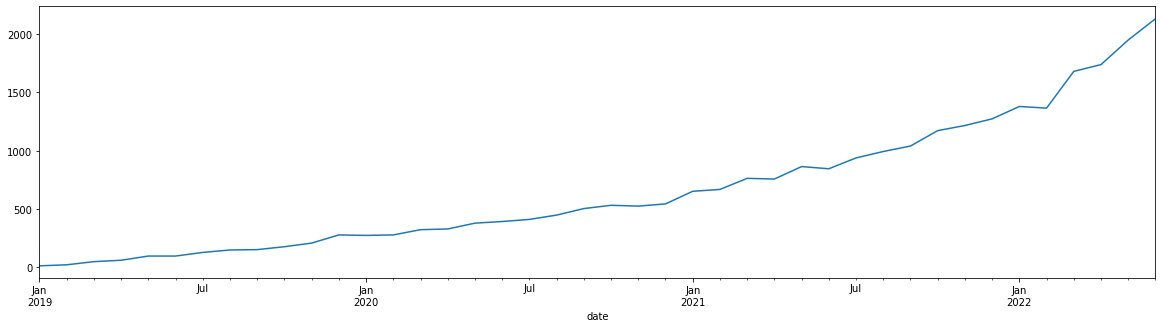

In [ ]:
sales.plot(figsize=(20,5))

## Data Preprocessing

In [ ]:
import numpy as np

window = 2
X = []
y = []
for i in range(window,len(sales)):
  if window+i<len(sales):
    X.append(sales[i:window+i].values.tolist())
    try:
      y.append(sales[window+i])
    except:
      pass
  else:
    break

X = np.array(X)
y = np.array(y)

In [ ]:
X

array([[  50,   62],
       [  62,   98],
       [  98,   98],
       [  98,  129],
       [ 129,  150],
       [ 150,  153],
       [ 153,  178],
       [ 178,  209],
       [ 209,  279],
       [ 279,  275],
       [ 275,  279],
       [ 279,  324],
       [ 324,  330],
       [ 330,  380],
       [ 380,  394],
       [ 394,  412],
       [ 412,  449],
       [ 449,  505],
       [ 505,  533],
       [ 533,  526],
       [ 526,  545],
       [ 545,  653],
       [ 653,  669],
       [ 669,  764],
       [ 764,  758],
       [ 758,  865],
       [ 865,  846],
       [ 846,  939],
       [ 939,  994],
       [ 994, 1041],
       [1041, 1173],
       [1173, 1217],
       [1217, 1274],
       [1274, 1380],
       [1380, 1366],
       [1366, 1681],
       [1681, 1739],
       [1739, 1950]])

In [ ]:
y

In [ ]:
train_size = round(len(X)*0.8)
X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

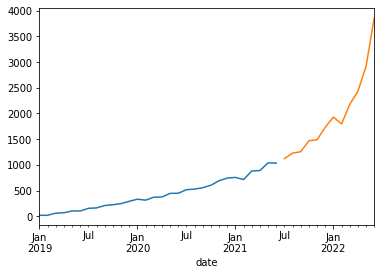

In [ ]:
sales[:train_size].plot()
sales[train_size:].plot()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

model_lr = LinearRegression(fit_intercept=True)
model_lr.fit(X_train_scaled,y_train)

y_pred_train = model_lr.predict(X_train_scaled)
y_pred_test = model_lr.predict(X_test_scaled)

print('Train MAE:',mean_absolute_error(y_train,y_pred_train))
print('Test MAE:',mean_absolute_error(y_test,y_pred_test))

Train MAE: 28.266233166321552
Test MAE: 281.4702307900982


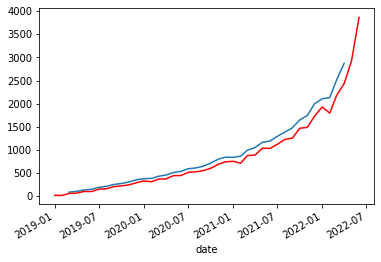

In [ ]:
import matplotlib.pyplot as plt

plt.plot(sales.index[window:-window],np.append(y_pred_train,y_pred_test))
sales.plot(color='red')

## Model Inference

In [ ]:
from datetime import datetime 

def forecasting(month):
  sales_forecast = sales.copy()
  window=2
  for i in range(month):
    X = sales_forecast[-window:].values.reshape(1,-1)
    X_scaled = scaler.transform(X)
    new_idx = datetime(sales_forecast.index.year[-1],sales_forecast.index.month[-1]+1,1)
    sales_forecast[new_idx] = round(model_lr.predict(X_scaled)[0])
  return sales_forecast

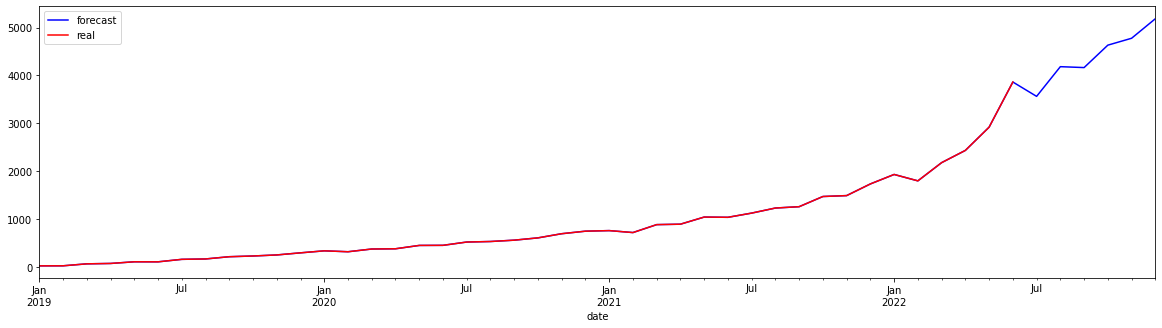

In [ ]:
sales_forecast = forecasting(6)
sales_forecast.plot(color='blue',label='forecast',figsize=(20,5))
sales.plot(color='red',label='real')
plt.legend()

In [ ]:
sales_forecast['2022-04':'2022-10']

date
2022-04-01    2433
2022-05-01    2919
2022-06-01    3863
2022-07-01    3563
2022-08-01    4184
2022-09-01    4165
2022-10-01    4634
Name: sales, dtype: int64

We can see that our sales on July 2022 is predicted by 3563 orders. So, we need to set that **our target on July 2022 is that have to reach 3563 orders**.

However, July 2022 has already running up to July 5th. So, we need to check the performance of our KPI today.

In [ ]:
july = client.query('''
SELECT extract(year from created_at) as year, extract(month from created_at) as month, count(order_id) as sales
FROM `bigquery-public-data.thelook_ecommerce.orders`
WHERE status='Shipped' and created_at between "2022-07-01" and "2022-07-05"
GROUP BY year,month
ORDER BY year,month ASC
''').to_dataframe()

july

,year,month,sales
0,2022,7,1390


In [ ]:
print('Sales KPI Achievement: {:.2f} %'.format(july.sales[0]*100/sales_forecast['2022-07-01']))

Sales KPI Achievement: 39.01 %
